**Подключение библиотек и скриптов**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score as r2
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import xgboost as xgb
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest,f_regression
import catboost as catb
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [4]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [5]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [6]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [7]:
def get_cat_features(df):
    
    cat_features_list = []
    object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
       
    for cf in object_cols:
        cat_features_list.append(df.columns.get_loc(cf))
    
    return cat_features_list

**Пути к директориям и файлам**

In [8]:
DATASET_PATH = 'C:/Users/1/Downloads/c_p/course_project_train.csv'
TEST_DATASET_PATH = 'C:/Users/1/Downloads/c_p/course_project_test.csv'

### Загрузка подготовленных датасетов<a class="anchor" id="data_loading"></a>

**Загрузка данных**

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
df = pd.read_csv(DATASET_PATH)

**Выделение признакового описания и целевой переменной**

In [10]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

In [12]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

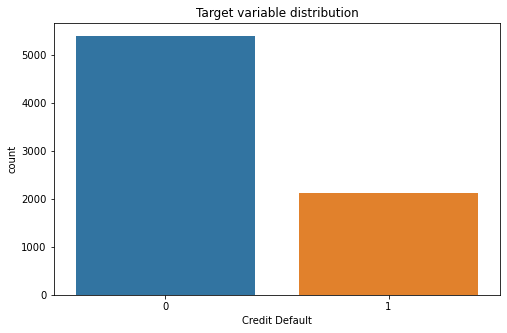

In [13]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

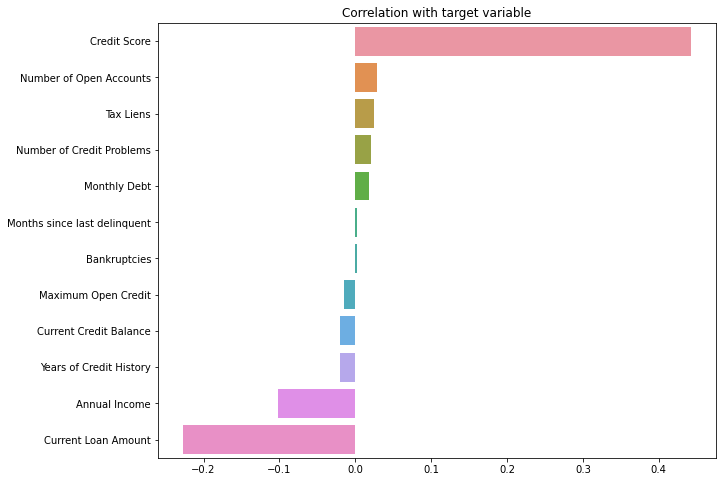

In [14]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Сильная корреляция таргета с Credit Score и Current Loan Amount

### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

**Матрица корреляций**

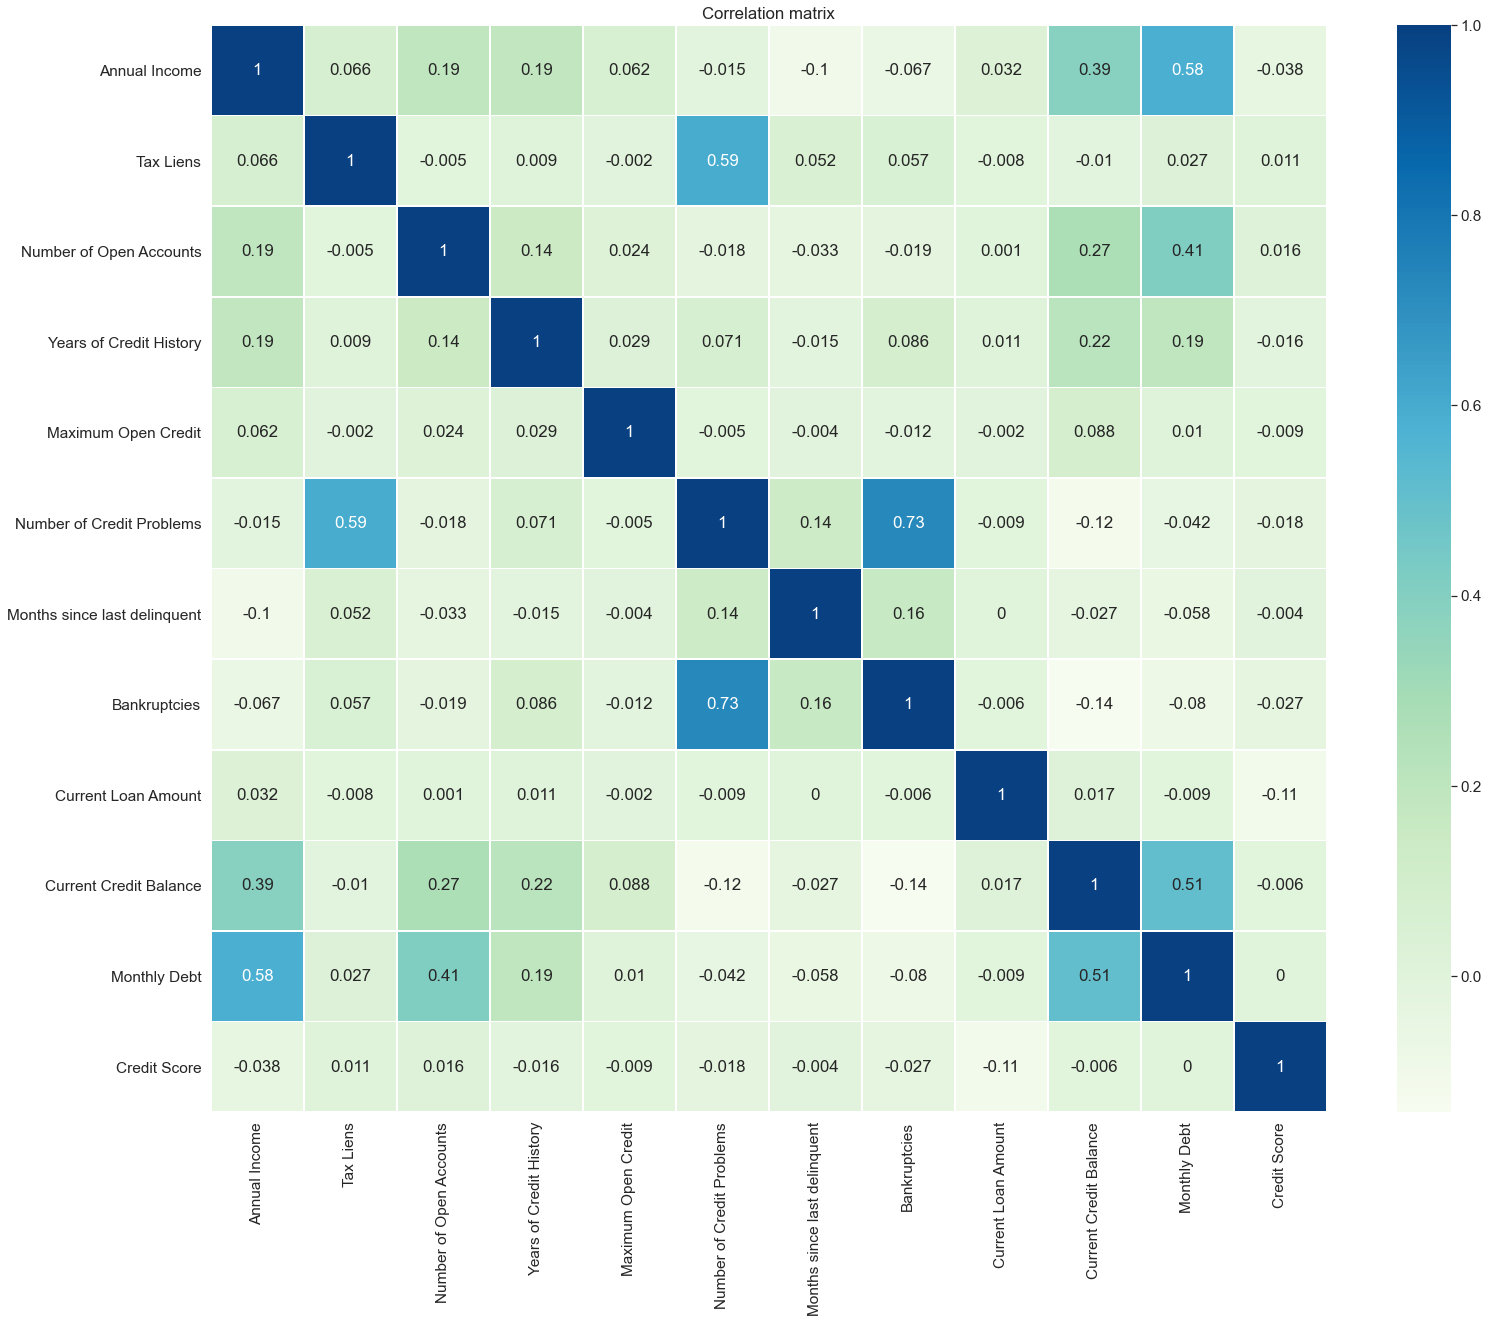

In [15]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [16]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Сильная корреляция банкротства и количества кредитных проблем, текущего кредитного баланса и месячной задолжности, годового дохода и ежемесячого долга, налоговых залогов и кредитных проблем

### Обработки пропусков и выбросов, генерация новых признаков<a class="anchor" id="features_analysis"></a>

In [17]:
df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
test_df.loc[test_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [18]:
df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)
test_df['Months since last delinquent'] = test_df['Months since last delinquent'].fillna(0)

In [19]:
df['Bankruptcies'].fillna(0.0, inplace=True)
test_df['Bankruptcies'].fillna(0.0, inplace=True)

In [20]:
df['Years in current job'].fillna('Unknown', inplace=True)
test_df['Years in current job'].fillna('Unknown', inplace=True)

In [21]:
job_years_dict = {'Unknown': 0,
                      '< 1 year': 0,
                      '1 year': 1,
                      '2 years': 2,
                      '3 years': 3,
                      '4 years': 4,
                      '5 years': 5,
                      '6 years': 6,
                      '7 years': 7,
                      '8 years': 8,
                      '9 years': 9,
                      '10+ years': 10}

In [22]:
df['Years_in_current_job'] = pd.Series(df['Years in current job'].map(job_years_dict), dtype=np.int8)
test_df['Years_in_current_job'] = pd.Series(test_df['Years in current job'].map(job_years_dict), dtype=np.int8)

df['No Tax Liens'] = (df['Tax Liens'] == 0)
df['No Credit Problems'] = (df['Number of Credit Problems'] == 0)
df['No Bankruptcies'] = (df['Bankruptcies'] == 0)
test_df['No Tax Liens'] = (test_df['Tax Liens'] == 0)
test_df['No Credit Problems'] = (test_df['Number of Credit Problems'] == 0)
test_df['No Bankruptcies'] = (test_df['Bankruptcies'] == 0)

df['Debt'] = 0
test_df['Debt'] = 0
df.loc[df['Purpose'] == 'debt consolidation', 'Debt'] = 1
test_df.loc[test_df['Purpose'] == 'debt consolidation', 'Debt'] = 1

In [23]:
df['Annual_Income_nan'] = 0
test_df['Annual_Income_nan'] = 0
df.loc[df['Annual Income'].isna(), 'Annual_Income_nan'] = 1
test_df.loc[test_df['Annual Income'].isna(), 'Annual_Income_nan'] = 1

In [24]:
median = df['Maximum Open Credit'].median()
df.loc[(df['Maximum Open Credit'] > 3568459) & (df['Home Ownership'] == 'Rent'), 'Maximum Open Credit'] = median
test_df.loc[(test_df['Maximum Open Credit'] > 3568459) & (test_df['Home Ownership'] == 'Rent'), 'Maximum Open Credit'] = median

In [25]:
df['Current Loan Amount'] = df['Current Loan Amount'] / 10000
test_df['Current Loan Amount'] = test_df['Current Loan Amount'] / 10000
df.loc[df['Current Loan Amount'] == 9999.9999, 'Current Loan Amount'] = df['Current Loan Amount'].median()
test_df.loc[test_df['Current Loan Amount'] == 9999.9999, 'Current Loan Amount'] = df['Current Loan Amount'].median()

In [26]:
df1 = df[np.isfinite(df['Annual Income'])]
test_df1 = test_df[np.isfinite(test_df['Annual Income'])]
df2 = df[df['Annual Income'].isnull()==True]
test_df2 = test_df[test_df['Annual Income'].isnull()==True]
y1=df1['Annual Income']
test_df_y1=test_df1['Annual Income']
df1=df1.drop('Annual Income',axis=1)
df2=df2.drop('Annual Income',axis=1)
test_df1=test_df1.drop('Annual Income',axis=1)
test_df2=test_df2.drop('Annual Income',axis=1)

In [27]:
df1=df1[['Years of Credit History','Maximum Open Credit','Current Loan Amount','Years_in_current_job','Number of Credit Problems', 'Monthly Debt', 'Current Credit Balance']]
df2=df2[['Years of Credit History','Maximum Open Credit','Current Loan Amount','Years_in_current_job','Number of Credit Problems', 'Monthly Debt', 'Current Credit Balance']]

In [28]:
xgb_model = xgb.XGBRegressor(n_estimators=400, max_depth=5, eta=0.01, subsample=0.5)
xgb_model.fit(df1,y1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
y_pred=xgb_model.predict(df2)
y_pred

array([1238990.4 ,  827007.56, 1525101.8 , ...,  769215.  , 2090834.9 ,
        764117.1 ], dtype=float32)

In [30]:
df2['Annual Income']=y_pred
df1['Annual Income']=y1
df1=df1[['Annual Income']]
df2=df2[['Annual Income']]
B=pd.concat([df1,df2])
B.sort_index(inplace=True)
df['Annual Income']=B

In [31]:
test_df1=test_df1[['Years of Credit History','Maximum Open Credit','Current Loan Amount','Years_in_current_job','Number of Credit Problems', 'Monthly Debt', 'Current Credit Balance']]
test_df2=test_df2[['Years of Credit History','Maximum Open Credit','Current Loan Amount','Years_in_current_job','Number of Credit Problems', 'Monthly Debt', 'Current Credit Balance']]

In [32]:
xgb_model = xgb.XGBRegressor(n_estimators=400, max_depth=5, eta=0.01, subsample=0.5)
xgb_model.fit(test_df1,test_df_y1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
y_pred=xgb_model.predict(test_df2)
test_df2['Annual Income']=y_pred
test_df1['Annual Income']=test_df_y1
test_df1=test_df1[['Annual Income']]
test_df2=test_df2[['Annual Income']]
B=pd.concat([test_df1,test_df2])
B.sort_index(inplace=True)
test_df['Annual Income']=B

In [34]:
df1 = df[np.isfinite(df['Credit Score'])]
test_df1 = test_df[np.isfinite(test_df['Credit Score'])]
df2 = df[df['Credit Score'].isnull()==True]
test_df2 = test_df[test_df['Credit Score'].isnull()==True]
y1=df1['Credit Score']
test_df_y1=test_df1['Credit Score']
df1=df1.drop('Credit Score',axis=1)
df2=df2.drop('Credit Score',axis=1)
test_df1=test_df1.drop('Credit Score',axis=1)
test_df2=test_df2.drop('Credit Score',axis=1)
df1=df1[['Years of Credit History','Maximum Open Credit','Current Loan Amount','Years_in_current_job','Number of Credit Problems', 'Monthly Debt', 'Current Credit Balance']]
df2=df2[['Years of Credit History','Maximum Open Credit','Current Loan Amount','Years_in_current_job','Number of Credit Problems', 'Monthly Debt', 'Current Credit Balance']]

In [35]:
xgb_model = xgb.XGBRegressor(n_estimators=400, max_depth=5, eta=0.01, subsample=0.5)
xgb_model.fit(df1,y1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
y_pred=xgb_model.predict(df2)

In [37]:
df2['Credit Score']=y_pred
df1['Credit Score']=y1
df1=df1[['Credit Score']]
df2=df2[['Credit Score']]
B=pd.concat([df1,df2])
B.sort_index(inplace=True)
df['Credit Score']=B

In [38]:
test_df1=test_df1[['Years of Credit History','Maximum Open Credit','Current Loan Amount','Years_in_current_job','Number of Credit Problems', 'Monthly Debt', 'Current Credit Balance']]
test_df2=test_df2[['Years of Credit History','Maximum Open Credit','Current Loan Amount','Years_in_current_job','Number of Credit Problems', 'Monthly Debt', 'Current Credit Balance']]

In [39]:
xgb_model = xgb.XGBRegressor(n_estimators=400, max_depth=5, eta=0.01, subsample=0.5)
xgb_model.fit(test_df1,test_df_y1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
y_pred=xgb_model.predict(test_df2)
test_df2['Credit Score']=y_pred
test_df1['Credit Score']=test_df_y1
test_df1=test_df1[['Credit Score']]
test_df2=test_df2[['Credit Score']]
B=pd.concat([test_df1,test_df2])
B.sort_index(inplace=True)
test_df['Credit Score']=B

In [41]:
pca = PCA(n_components=1, random_state=42)
scaler = RobustScaler()
problems_scaled = pd.DataFrame(scaler.fit_transform(df[['Bankruptcies', 'Number of Credit Problems', 'Tax Liens']]))
df['Problems'] = pca.fit_transform(problems_scaled)
problems_scaled = pd.DataFrame(scaler.fit_transform(test_df[['Bankruptcies', 'Number of Credit Problems', 'Tax Liens']]))
test_df['Problems'] = pca.fit_transform(problems_scaled)

In [42]:
credit_scaled = pd.DataFrame(scaler.fit_transform(df[['Current Credit Balance', 'Monthly Debt']]))
df['Credit_Balance'] = pca.fit_transform(credit_scaled)
credit_scaled = pd.DataFrame(scaler.fit_transform(test_df[['Current Credit Balance', 'Monthly Debt']]))
test_df['Credit_Balance'] = pca.fit_transform(credit_scaled)

In [43]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
Years_in_current_job               int8
Annual_Income_nan                 int64
Problems                        float64
Credit_Balance                  float64
dtype: object

In [44]:
int_columns = [
               'Annual Income',
               'Tax Liens',
               'Number of Open Accounts', 'Years of Credit History', 'Months since last delinquent', 'Current Loan Amount',
               'Maximum Open Credit',
               'Number of Credit Problems',
               'Bankruptcies',
               'Current Credit Balance',
               'Monthly Debt',
               'Credit Score', 'Annual_Income_nan', 'Credit_Balance', 'Problems']
    
df[int_columns] = df[int_columns].astype('int32')

In [45]:
test_df[int_columns] = test_df[int_columns].astype('int32')

### Приведение типов для модели CatBoost

In [46]:
df.dtypes

Home Ownership                  object
Annual Income                    int32
Years in current job            object
Tax Liens                        int32
Number of Open Accounts          int32
Years of Credit History          int32
Maximum Open Credit              int32
Number of Credit Problems        int32
Months since last delinquent     int32
Bankruptcies                     int32
Purpose                         object
Term                            object
Current Loan Amount              int32
Current Credit Balance           int32
Monthly Debt                     int32
Credit Score                     int32
Credit Default                   int64
Years_in_current_job              int8
Annual_Income_nan                int32
Problems                         int32
Credit_Balance                   int32
dtype: object

In [47]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [48]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

In [49]:
for colname in CAT_FEATURE_NAMES:
    test_df[colname] = pd.Categorical(test_df[colname])
    
test_df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

cat_features = get_cat_features(df)
cat_features

In [50]:
features_to_drop = ['Bankruptcies', 'Number of Credit Problems', 'Tax Liens', 'Current Credit Balance', 'Monthly Debt']
df = df.drop(columns=features_to_drop)
test_df = test_df.drop(columns=features_to_drop)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [51]:
bal_df = df.loc[df['Credit Default'] == 1]
X = pd.concat([df, bal_df], axis=0)

In [52]:
y = X[TARGET_NAME]
X = X.drop(columns=TARGET_NAME)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.20, random_state=42, stratify=y)

In [54]:
X_train.shape, X_test.shape, test_df.shape

((7690, 15), (1923, 15), (2500, 15))

In [55]:
cat_features = get_cat_features(df)
cat_features

[0, 2, 7, 8]

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

In [56]:
final_params = {'silent': True,
                 'random_state': 42,
                 'n_estimators': 1200,
                 'eval_metric': 'F1',
                 'custom_metric': 'Precision',
                 'learning_rate': 0.01,
                 'early_stopping_rounds': 800
               }

In [57]:
%%time

final_model = catb.CatBoostClassifier(**final_params)
final_model.fit(X_train, y_train, cat_features)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      4309
           1       0.83      0.64      0.72      3381

    accuracy                           0.78      7690
   macro avg       0.79      0.77      0.77      7690
weighted avg       0.79      0.78      0.78      7690

TEST

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      1078
           1       0.73      0.59      0.65       845

    accuracy                           0.72      1923
   macro avg       0.73      0.71      0.71      1923
weighted avg       0.73      0.72      0.72      1923

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               892  186
1               343  502
Wall time: 45.8 s


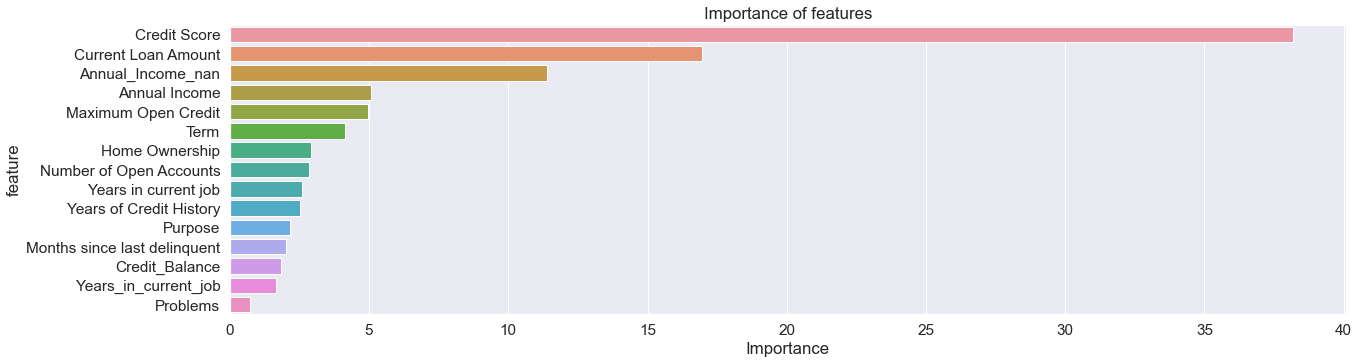

In [58]:
important_features_top = show_feature_importances(X.columns, final_model.feature_importances_, get_top=15)

In [59]:
test_predictions = final_model.predict(test_df)
submit = pd.read_csv('C:/Users/1/Downloads/c_p/sampleSubmission.csv')
submit['Credit Default'] = test_predictions
submit.to_csv('C:/Users/1/Downloads/c_p/submission.csv', index=False)
submit.head()

,Id,Credit Default
0,7500,1
1,7501,1
2,7502,1
3,7503,0
4,7504,0


In [60]:
test_predictions

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [61]:
test_predictions.tofile('C:/Users/1/Downloads/c_p/SOkruzhnov_predictions.csv',sep=',',format='%10.5f')